In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
from pathlib import Path

import pandas as pd
from transformers import AutoProcessor, LayoutLMv3ForTokenClassification
import torch
import numpy as np
 
from mozilla_sec_eia.ex_21.inference import (
    clean_extracted_df,
    create_inference_dataset,
    get_flattened_mode_predictions,
    perform_inference
)
from mozilla_sec_eia.utils.layoutlm import (
    iob_to_label,
    load_model,
    draw_boxes_on_img,
    unnormalize_box
)

# Extract into a table

In [3]:
has_labels=False

In [4]:
label_list = ['O', 'B-Subsidiary', 'I-Subsidiary', 'B-Loc', 'I-Loc', 'B-Own_Per']
id2label = {k: v for k,v in enumerate(label_list)}
label2id = {v: k for k,v in enumerate(label_list)}

In [27]:
model_checkpoint = load_model()

I0000 00:00:1722298284.493576 2999721 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
/Users/katielamb/CatalystCoop/mozilla-sec-eia/src/mozilla_sec_eia/ex_21/train_extractor.py:149: FutureWarning: The 'transformers' MLflow Models integration is known to be compatible with the following package version ranges: ``4.25.1`` -  ``4.41.0``. MLflow Models integrations with transformers may not succeed when used with package versions outside of this range.
  return mlflow.transformers.load_model(


2024/07/29 17:13:40 INFO mlflow.transformers: 'models:/layoutlm_extractor/1' resolved as 'gs://mlflow-artifacts-mozilla/3/6a0559c745ac4e839d102c8f1f9660ea/artifacts/layoutlm_extractor'


2024/07/29 17:13:41 WARNING mlflow.transformers.model_io: Could not specify device parameter for this pipeline type.Falling back to loading the model with the default device.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
model = model_checkpoint["model"]
processor = model_checkpoint["tokenizer"]

In [14]:
# or load a model and processor from a path
model_path = Path("../models/layoutlm_v1_50_labeled_docs")
model = LayoutLMv3ForTokenClassification.from_pretrained(model_path,
                                                         id2label=id2label,
                                                         label2id=label2id)
processor = AutoProcessor.from_pretrained(
        "microsoft/layoutlmv3-base", apply_ocr=False
    )

In [8]:
pdf_dir = Path("../sec10k_filings/pdfs")

In [9]:
# only necessary if using data with labels
labeled_json_dir = Path("../sec10k_filings/labeled_jsons_v0.1")

In [11]:
if has_labels:
    dataset = create_inference_dataset(
            pdfs_dir=pdf_dir, labeled_json_dir=labeled_json_dir, has_labels=has_labels
        )
else:
    dataset = create_inference_dataset(
            pdfs_dir=pdf_dir, has_labels=has_labels
        )

In [12]:
# only use 3 examples
dataset_index = [0, 1, 2]

In [39]:
# check but I think this is mainly slow because it's checking to make sure PDFs and JSONs are cached
logit_list, pred_list, all_output_df = perform_inference(pdf_dir,
                                          model,
                                          processor,
                                          dataset_index,
                                          labeled_json_dir,
                                          has_labels,
                                          device="mps"
                                         )

/Users/katielamb/mambaforge/envs/mozilla-sec-eia/lib/python3.11/site-packages/transformers/modeling_utils.py:1060: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/Users/katielamb/mambaforge/envs/mozilla-sec-eia/lib/python3.11/site-packages/transformers/modeling_utils.py:1060: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/Users/katielamb/mambaforge/envs/mozilla-sec-eia/lib/python3.11/site-packages/transformers/modeling_utils.py:1060: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [43]:
doc_stride = 128

def convert_ner_tags_to_id(ner_tags):
    return [int(label2id[ner_tag]) for ner_tag in ner_tags]

def visual_inputs_with_labels():
    for i in range(len(pred_list)):
        predictions = pred_list[i]
        example = dataset[i]
        output_df = all_output_df[all_output_df["id"] == example["id"]]
        image = example["image"]
        words = example["tokens"]
        boxes = example["bboxes"]
        ner_tags = convert_ner_tags_to_id(example["ner_tags"])
        encoding = processor(
            image,
            words,
            boxes=boxes,
            word_labels=ner_tags,
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            return_offsets_mapping=True,
            return_overflowing_tokens=True,
            max_length=512,  # this is the maximum max_length
            stride=doc_stride,
        )
        yield predictions, encoding, image, output_df, example

def visual_inputs():
    for i in range(len(pred_list)):
        predictions = pred_list[i]
        example = dataset[i]
        output_df = all_output_df[all_output_df["id"] == example["id"]]
        image = example["image"]
        words = example["tokens"]
        boxes = example["bboxes"]
        encoding = processor(
            image,
            words,
            boxes=boxes,
            return_tensors="pt",
            truncation=True,
            return_offsets_mapping=True,
            padding="max_length",
            return_overflowing_tokens=True,
            max_length=512,
            stride=doc_stride
        )
        yield predictions, encoding, image, output_df, example

if has_labels:
    gen = visual_inputs_with_labels()
else:
    gen = visual_inputs()

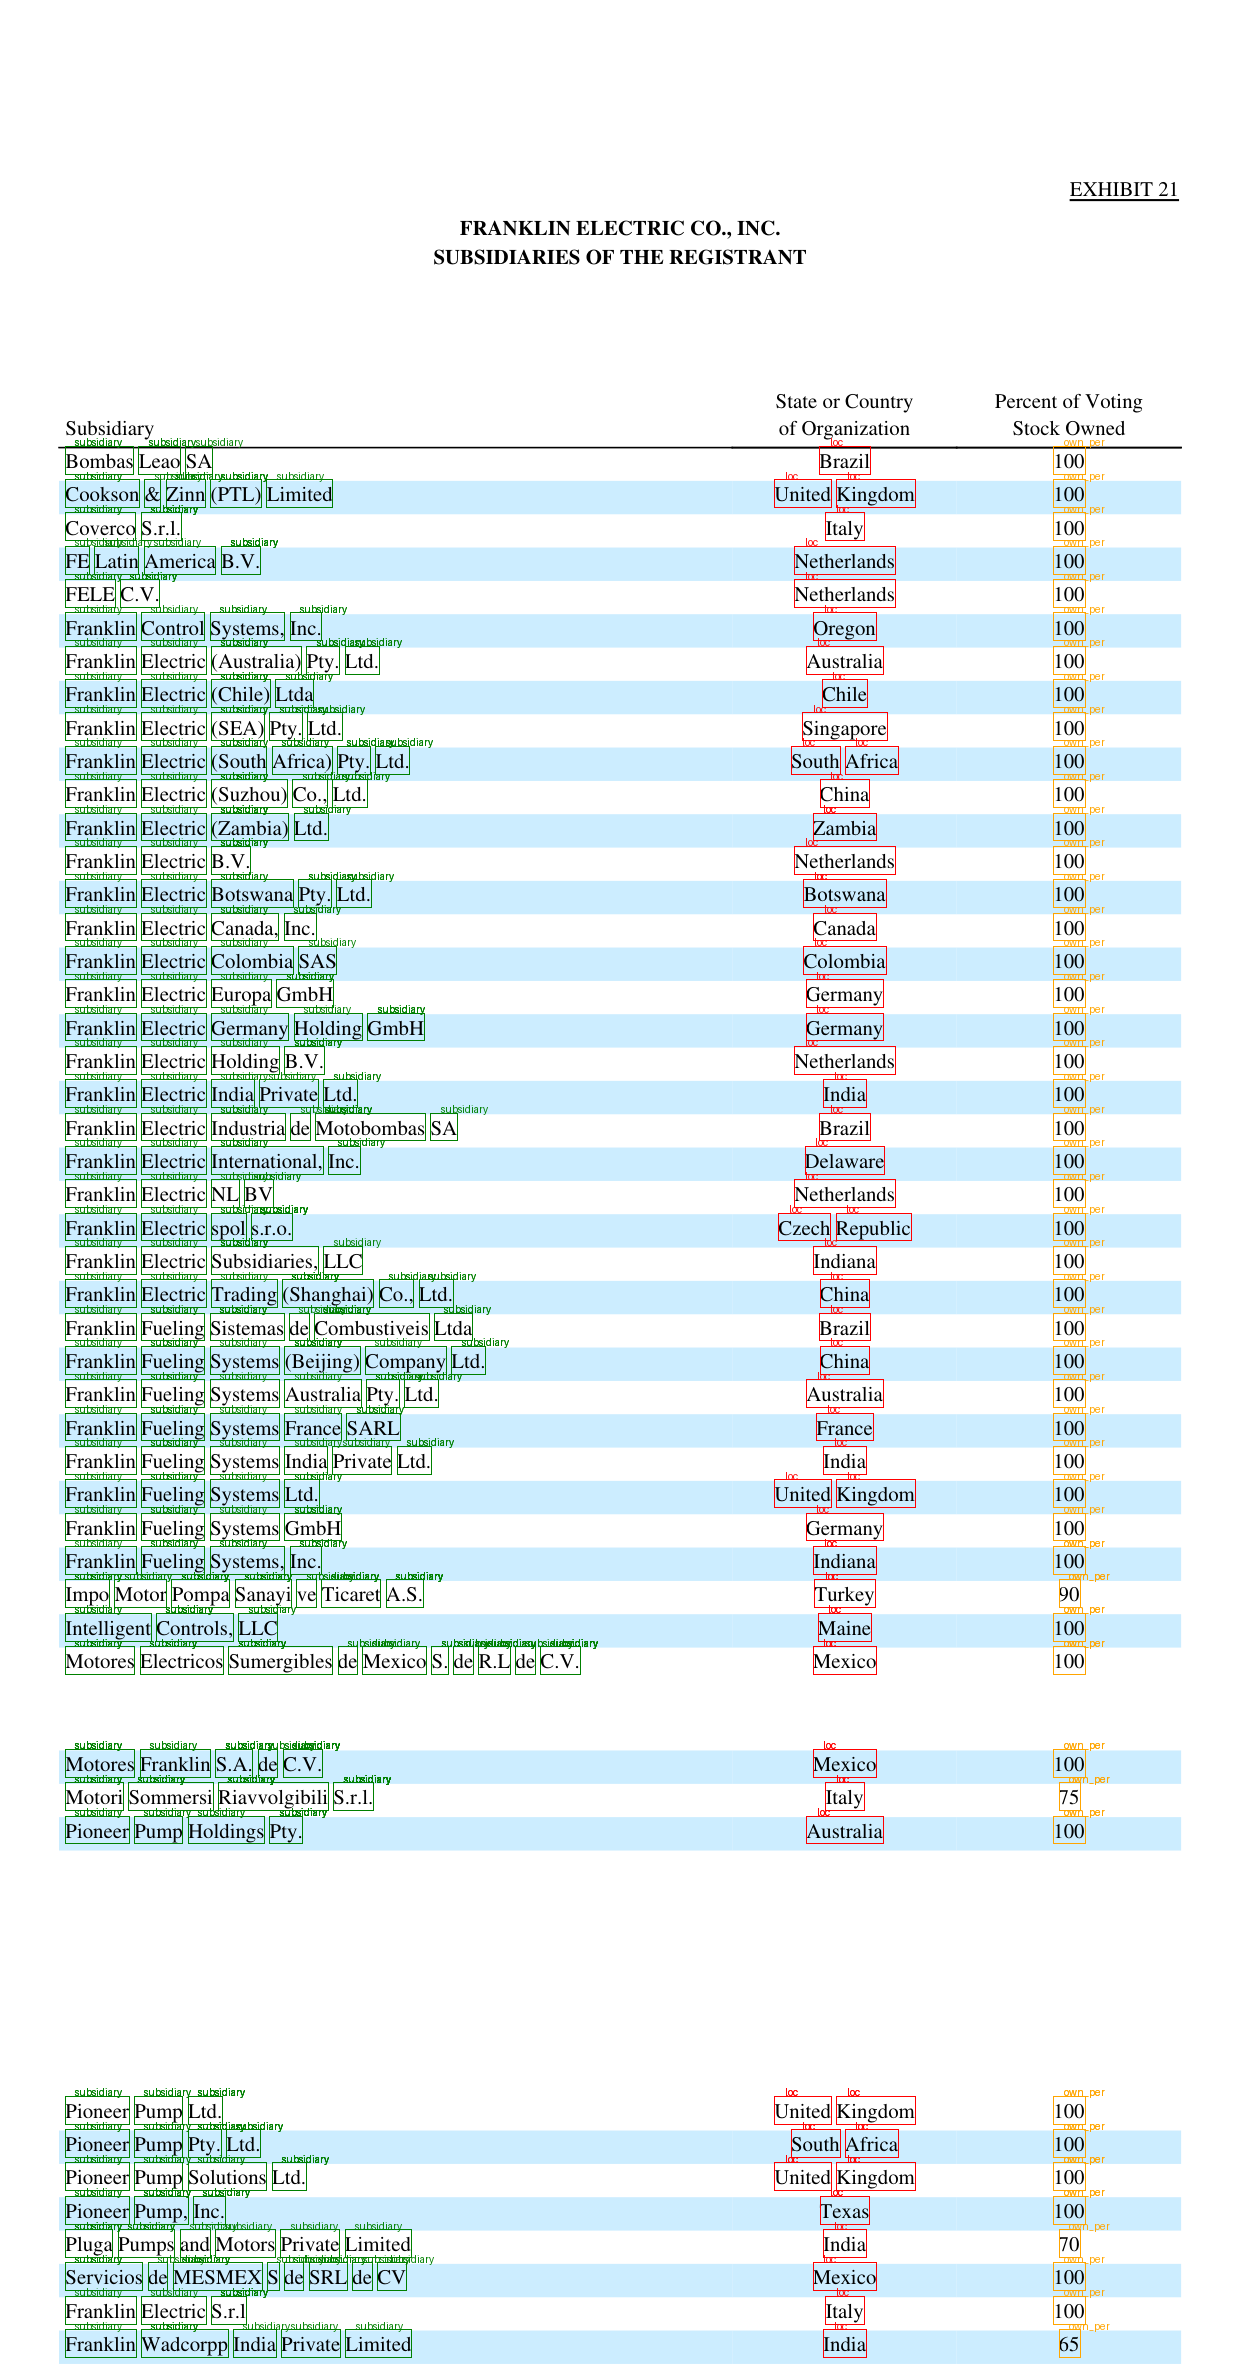

In [46]:
# TODO: also add visualizaton for wrong predictions
predictions, encoding, image, output_df, example = next(gen)
width, height = image.size
token_boxes = encoding.bbox.flatten(start_dim=0, end_dim=1).tolist()
boxes = [unnormalize_box(box, width, height) for box in token_boxes]
if has_labels:
    labels = encoding.labels.flatten(start_dim=0, end_dim=1).tolist()
    predictions = torch.tensor(predictions).view(-1).tolist()
    true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
    true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
    true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]
    draw_boxes_on_img(true_predictions, true_boxes, image, width, height)
else:
    predictions = torch.tensor(predictions).view(-1).tolist()
    true_predictions = [model.config.id2label[pred] for pred in predictions]
    draw_boxes_on_img(true_predictions, boxes, image, width, height)
image

# Line By Line Debugging

In [ ]:
encoding["pixel_values"] = torch.stack(encoding["pixel_values"])
# Since one example might give us several features if it has a long context, we need a map from a feature to
# its corresponding example. This key gives us just that.
sample_mapping = encoding.pop("overflow_to_sample_mapping")
# The offset mappings will give us a map from token to character position in the original context. This will
# help us compute the start_positions and end_positions.
offset_mapping = encoding.pop("offset_mapping")

In [ ]:
token_boxes_tensor = encoding["bbox"].flatten(start_dim=0, end_dim=1)
predictions_tensor = torch.tensor(predictions)
mode_predictions = get_flattened_mode_predictions(token_boxes_tensor, predictions_tensor) 
token_boxes = encoding["bbox"].flatten(start_dim=0, end_dim=1).tolist()
predicted_labels = [model.config.id2label[pred] for pred in mode_predictions]
simple_preds = [_iob_to_label(pred).lower() for pred in predicted_labels]

In [ ]:
len(predicted_labels), len(token_boxes), len(simple_preds)

In [ ]:
bbox_cols = ["top_left_x", "top_left_y", "bottom_right_x", "bottom_right_y"]

In [ ]:
df = pd.DataFrame(data=token_boxes, columns=bbox_cols)
df.loc[:, "iob_pred"] = predicted_labels
df.loc[:, "pred"] = simple_preds
invalid_mask = ((df["top_left_x"] == 0) & (df["top_left_y"] == 0) & (df["bottom_right_x"] == 0) & (df["bottom_right_y"] == 0))
df = df[~invalid_mask]

In [ ]:
# we want to get actual words on the dataframe, not just subwords that correspond to tokens
words_df = pd.DataFrame(data=example["bboxes"], columns=bbox_cols)
words_df.loc[:, "word"] = example["tokens"]

In [ ]:
df = df.merge(words_df, how="left", on=bbox_cols).drop_duplicates(subset=bbox_cols + ["pred", "word"])

In [ ]:
entities_df = df.sort_values(by=["top_left_y", "top_left_x"])
entities_df = entities_df[entities_df["pred"] != "other"]

In [ ]:
entities_df["group"] = (entities_df['iob_pred'].str.startswith('B-')).cumsum()

In [ ]:
grouped_df = entities_df.groupby(["group", "pred"])["word"].apply(" ".join).reset_index()[["pred", "word"]]

In [ ]:
grouped_df["row"] = (grouped_df['pred'].str.startswith('subsidiary')).cumsum()

In [ ]:
final_df = grouped_df.pivot_table(index='row', columns='pred', values='word', aggfunc=lambda x: ' '.join(x)).reset_index()

In [ ]:
clean_extracted_df(final_df)

In [ ]:
image